In [1]:
import logging
# set seed
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as exp
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
from plot import *
from sk_models import setup_pls_models_exh, StandardScaler, PLSRegression, DeepKNN,CustomWrapper,KNNBoost
from tqdm.notebook import tqdm, trange

seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)
import gc
torch.cuda.empty_cache()
gc.collect()

print(f"GPU detected is {torch.cuda.get_device_name(0)}")

GPU detected is GeForce GTX 970


In [2]:
id_col_db = {'A_C_OF_ALPHA':["sample_id"],
             'A_C_OF_SIWARE':[],
             'A_AL_RT':[],
             'PLN7':["db_id", "sample_id"],
             'mango_684_990': ['Set','Season','Region','Date','Type','Cultivar','Pop','Temp',"FruitID"]
            }

output_col_db= {'A_C_OF_ALPHA':None,
             'A_C_OF_SIWARE':None,
             'A_AL_RT':None,
             'PLN7':None,
             'mango_684_990': ['DM']
            }


In [3]:
#setup input and output formats, load data

file_name = "PLN7.csv"
dataset_name = re.sub(r'\.(?=csv$)[^.]+$', '',file_name)


data_path = Path('D:/workspace/lazydeep/data/soil_data/')
model_path = Path('D:/workspace/lazydeep/experiments/2.00/')
log_path = Path("D:/workspace/lazydeep/experiments/2.04_reverse")

data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
model_dir = model_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)

if not log_dir.exists():
    log_dir.mkdir()
print(log_dir)

id_cols =id_col_db[dataset_name]
output_cols = output_col_db[dataset_name]


D:\workspace\lazydeep\experiments\2.04_reverse\PLN7


In [4]:
data = pd.read_csv(data_file)
data = data.sample(frac=1)
data = ut.sample_data(data,random_state)
nrow, ncol = data.shape
n_features = ncol - 1-len(id_cols)

dataset = TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
print(data.shape)

(10000, 129)


In [5]:
# set logging, in this case the root logger
ut.setup_logger(logger_name="",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
summary_logger = logging.getLogger("summary")
tb = SummaryWriter(log_dir/"tb")


In [6]:
n_models = 100
model_names = [f"random_{i}" for i in range(0,n_models)]
deep_models = {name:torch.load(model_dir/"models"/name/"_model") for name in model_names}
#configs =  {name:Configuration().load(model_dir/"models"/name/"_config") for name in model_names}
#for each model, load state
print(f"Loaded {len(deep_models)} models")
#print(deep_models)
fixed_hyperparams = {'bs': 32,'loss': nn.MSELoss(),'epochs': 100}
preprocessing = StandardScaler()

model_names = deep_models.keys()
for name in model_names:
        sub_path = log_dir / name
        if not sub_path.exists():
            sub_path.mkdir()

Loaded 100 models


In [7]:
if dataset_name == 'mango_684_990':
    eval_ = MangoesSplitter(preprocessing=preprocessing,tensorboard=None,time=True,random_state=random_state)
else:
    eval_ = CrossValEvaluation(preprocessing=preprocessing,tensorboard=None,time=True,random_state=random_state)

In [8]:
scores={} #->model->knn:{fold_0:number,...,fold_n:number,mean:number,median:number
preds={} #model-> foldsxknn_models
deep_scores_dict={}
deep_preds_dict={}
actual_y = None
device = "cpu" 

load_fun_cv = lambda name,model, fold : model.load_state(model_dir/'models'/name/f"_fold_{fold}")
load_fun_pp_cv = None #lambda fold : preprocessing.from_state(preprocessing.load_state(model_dir/'preprocessing'/f"_fold_{fold}"))
load_fun_build = lambda name,model : model.load_state(model_dir/'models'/name/f"_final")
load_fun_pp_build = None #lambda : preprocessing.from_state(preprocessing.load_state(model_dir/'preprocessing'/f"_final"))


In [9]:
deep_scheme = DeepScheme(None, fixed_hyperparams=fixed_hyperparams,loss_eval=loss_target,device=device,tensorboard=tb,adaptive_lr=False,update=False)
deep_scores, deep_preds, _ , _, _,_ = eval_.evaluate(deep_models,dataset,deep_scheme,logger_name="log",load_fun=load_fun_cv,load_fun_pp=load_fun_pp_cv)
deep_scores_final, deep_preds_final, _ ,_, _,_ = eval_.build(deep_models,dataset,deep_scheme,logger_name="test_log",load_fun=load_fun_build,load_fun_pp=load_fun_pp_build)

Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Tested (test) on 1667 instances with mean losses of: random_0:168.6752,random_1:142.1982,random_2:177.255,random_3:2788.8217,random_4:160.6797,random_5:154.4269,random_6:2779.8074,random_7:401.2411,random_8:2765.041,random_9:149.3919,random_10:167.512,random_11:169.7688,random_12:153.2087,random_13:161.1382,random_14:222.6899,random_15:160.8311,random_16:161.9417,random_17:176.623,random_18:155.8045,random_19:302.548,random_20:160.1394,random_21:155.9266,random_22:155.6808,random_23:160.6616,random_24:466.815,random_25:135.623,random_26:167.997,random_27:155.127,random_28:179.1668,random_29:136.1725,random_30:162.3986,random_31:160.6022,random_32:2757.4355,random_33:2775.6764,random_34:156.4009,random_35:162.9483,random_36:158.9109,random_37:147.8967,random_38:165.4038,random_39:2747.4657,random_40:170.8331,random_41:139.9774,random_42

In [10]:
all_scores = []
for k,v in ut.flip_dicts(deep_scores).items():
    dict1 = {'model_num':k,"predictor":"deep"}
    all_scores.append({**dict1,**v})

all_scores_final = []
for k,v in ut.flip_dicts(deep_scores_final).items():
    dict1 = {'model_num':k,"predictor":"deep"}
    all_scores_final.append({**dict1,**v})

In [11]:
n = 30
best_n = []
scores_df_sorted = pd.DataFrame(all_scores).sort_values(by='MSE')
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    print(s)
    if i < n:
        best_n.append(row['model_num'])

0 - random_29 - deep - 136.1725005096637 - 132.73565888018686 - 144.03927211383896 - 116.98450558812392 - 125.26079097715747 - 131.04092569468253 - 0.7267939682642388
1 - random_60 - deep - 142.17859075050833 - 128.13758790600278 - 142.85257588222345 - 122.92048939937303 - 132.18773698749519 - 133.65686071986772 - 0.721340029170626
2 - random_63 - deep - 139.99827609551332 - 136.84030156859254 - 150.87722592963098 - 119.90759105155735 - 129.62207239615816 - 135.45165808914675 - 0.7175980724923514
3 - random_41 - deep - 139.9773749138112 - 134.79085337107384 - 143.33308914999228 - 127.02502206937463 - 133.13876126622523 - 135.65435717780355 - 0.7171754670097146
4 - random_15 - deep - 160.83109276582184 - 139.18237164639825 - 142.10121095516615 - 112.93918198382869 - 129.92729984755132 - 136.99996686917987 - 0.714370017627415
5 - random_38 - deep - 165.40380923906773 - 126.28380756343849 - 151.49548406892717 - 117.41265477138121 - 128.35157377007198 - 137.79304447122234 - 0.7127165373626

In [12]:
scores_df_sorted_final = pd.DataFrame(all_scores_final).sort_values(by='MSE')

for i,(index,row) in enumerate(scores_df_sorted_final.iterrows()):
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    print(s)

0 - random_60 - deep - 125.80911623732636 - 0.7385531124617956
1 - random_25 - deep - 126.50414113452753 - 0.7371087648535346
2 - random_89 - deep - 127.04149021236918 - 0.735992087079102
3 - random_59 - deep - 128.68949149600525 - 0.7325673367974703
4 - random_75 - deep - 128.9325215528976 - 0.7320622903123423
5 - random_38 - deep - 129.77903000569577 - 0.7303031411594194
6 - random_50 - deep - 131.2077916805784 - 0.7273339978723203
7 - random_4 - deep - 131.8868952787036 - 0.7259227366906511
8 - random_41 - deep - 134.28216908942576 - 0.7209450617705464
9 - random_29 - deep - 135.5702412752982 - 0.7182682886241107
10 - random_0 - deep - 135.7012607060716 - 0.7179960140592205
11 - random_51 - deep - 135.83677560040803 - 0.7177143973656219
12 - random_20 - deep - 135.83817254590082 - 0.7177114943402922
13 - random_9 - deep - 136.25181961887546 - 0.716851884615632
14 - random_63 - deep - 137.08992446864116 - 0.7151101991880946
15 - random_74 - deep - 137.24237700707667 - 0.7147933839773

In [13]:
def build_predictors(n,deep):
    predictors = {}
    for i in [5,10,20,50,100]:
        if i* 2 < n:
            #predictors[f'knn_uu_n={i}'] = KNNBoost(deep,n_neighbors=i, weights='uniform',errors='uniform',convolution='additive',reverse=True)
            #predictors[f'knn_ut_n={i}'] = KNNBoost(deep,n_neighbors=i, weights='uniform',errors='triangle',convolution='additive',reverse=True)
            #predictors[f'knn_tu_n={i}'] = KNNBoost(deep,n_neighbors=i, weights='triangle',errors='uniform',convolution='additive',reverse=True)
            predictors[f'knn_tta_n={i}'] = KNNBoost(deep,n_neighbors=i, weights='triangle',errors='triangle',convolution='additive',reverse=True)
            predictors[f'knn_ttm_n={i}'] = KNNBoost(deep,n_neighbors=i, weights='triangle',errors='triangle',convolution='multiplicative',reverse=True)
            predictors[f'knn_tta_r_n={i}'] = KNNBoost(deep,n_neighbors=i, weights='triangle',errors='triangle',convolution='additive',reverse=False)
            predictors[f'knn_ttm_r_n={i}'] = KNNBoost(deep,n_neighbors=i, weights='triangle',errors='triangle',convolution='multiplicative',reverse=False)
    return predictors

deep_models = {k:v for k,v in deep_models.items() if k in best_n}
for deep_name,deep_model in tqdm(deep_models.items()):
    #if int(deep_name.replace("random_",""))>80:
        logging.getLogger().info(f"Running model {deep_name}")
        temp_dict = {deep_name:deep_model}

        lwr_scheme = BoostScheme(boost_models = build_predictors(nrow,deep_model),loss_fun_sk = mean_squared_error)
        lwr_scores, lwr_preds, _ , _, _,_= eval_.evaluate(temp_dict,dataset,lwr_scheme,logger_name="log")
        lwr_scores_final, lwr_preds_final, _ , _, _,_= eval_.build(temp_dict,dataset,lwr_scheme,logger_name="test_log")

        #scores
        for k,v in ut.flip_dicts(lwr_scores).items(): 
            dict1 = {'model_num':deep_name,"predictor":k}
            all_scores.append({**dict1,**v})

        for k,v in ut.flip_dicts(lwr_scores_final).items():
            dict1 = {'model_num':deep_name,"predictor":k}
            all_scores_final.append({**dict1,**v})

        lwr_preds['deep'] = deep_preds[deep_name]
        lwr_preds_final['deep'] = deep_preds_final[deep_name]

        lwr_preds.to_csv(log_dir/deep_name/ f"predictions.csv",index=False)
        lwr_preds_final.to_csv(log_dir/deep_name/ f"predictions_test.csv",index=False)

        #preds
        # todo save predictions - appending solns
        plot_preds_and_res(lwr_preds,name_lambda=lambda x:f"{deep_name} with {x} predictor",save_lambda= lambda x:f"deep_lwr{x}",save_loc=log_dir/deep_name)


  0%|          | 0/30 [00:00<?, ?it/s]

Running model random_0'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:48.7066,knn_ttm_n=5:26.7076,knn_tta_r_n=5:46.6627,knn_ttm_r_n=5:62.5606,knn_tta_n=10:64.4476,knn_ttm_n=10:41.0375,knn_tta_r_n=10:65.9428,knn_ttm_r_n=10:62.0187,knn_tta_n=20:74.6572,knn_ttm_n=20:53.1662,knn_tta_r_n=20:76.9979,knn_ttm_r_n=20:69.2519,knn_tta_n=50:83.1049,knn_ttm_n=50:69.14,knn_tta_r_n=50:84.8481,knn_ttm_r_n=50:78.858,knn_tta_n=100:87.4997,knn_ttm_n=100:78.5663,knn_tta_r_n=100:88.8164,knn_ttm_r_n=100:84.174'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:124.1277,knn_ttm_n=5:152.2547,knn_tta_r_n=5:85.2973,knn_ttm_r_n=5:92.7205,knn_tta_n=10:100.8972,knn_ttm_n=10:125.3148,knn_tta_r_n=10:80.1791,knn_ttm_r_n=10:83.4527,knn_tta_n=20:89.4256,knn_ttm_n=20:106.0347,knn_tta_r_n=20:78.8481,knn_ttm_r_n=20:79.887,knn_tta_n=50:84

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_1'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:53.4898,knn_ttm_n=5:36.4642,knn_tta_r_n=5:53.7629,knn_ttm_r_n=5:72.9459,knn_tta_n=10:72.4586,knn_ttm_n=10:56.7158,knn_tta_r_n=10:75.0667,knn_ttm_r_n=10:76.855,knn_tta_n=20:85.1629,knn_ttm_n=20:74.9398,knn_tta_r_n=20:87.3325,knn_ttm_r_n=20:85.8706,knn_tta_n=50:92.798,knn_ttm_n=50:89.0093,knn_tta_r_n=50:94.5463,knn_ttm_r_n=50:93.4815,knn_tta_n=100:96.5023,knn_ttm_n=100:94.4407,knn_tta_r_n=100:97.6968,knn_ttm_r_n=100:96.689'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:143.215,knn_ttm_n=5:170.8178,knn_tta_r_n=5:105.8737,knn_ttm_r_n=5:111.7425,knn_tta_n=10:123.0356,knn_ttm_n=10:149.0958,knn_tta_r_n=10:102.9132,knn_ttm_r_n=10:103.7446,knn_tta_n=20:110.6073,knn_ttm_n=20:127.2462,knn_tta_r_n=20:102.3974,knn_ttm_r_n=20:102.0145,knn_tta

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_4'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:57.3957,knn_ttm_n=5:29.6144,knn_tta_r_n=5:58.5514,knn_ttm_r_n=5:79.4893,knn_tta_n=10:79.201,knn_ttm_n=10:47.3925,knn_tta_r_n=10:82.7018,knn_ttm_r_n=10:80.523,knn_tta_n=20:93.1434,knn_ttm_n=20:65.4454,knn_tta_r_n=20:96.416,knn_ttm_r_n=20:89.6061,knn_tta_n=50:102.5577,knn_ttm_n=50:86.7075,knn_tta_r_n=50:105.4632,knn_ttm_r_n=50:100.2752,knn_tta_n=100:107.0216,knn_ttm_n=100:98.3864,knn_tta_r_n=100:109.2823,knn_ttm_r_n=100:105.9628'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:166.1174,knn_ttm_n=5:198.1009,knn_tta_r_n=5:120.1818,knn_ttm_r_n=5:125.7336,knn_tta_n=10:135.0844,knn_ttm_n=10:167.1618,knn_tta_r_n=10:116.1544,knn_ttm_r_n=10:119.137,knn_tta_n=20:121.5543,knn_ttm_n=20:139.4754,knn_tta_r_n=20:113.9948,knn_ttm_r_n=20:115.5432,k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_5'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:55.371,knn_ttm_n=5:30.2077,knn_tta_r_n=5:58.1771,knn_ttm_r_n=5:79.065,knn_tta_n=10:75.0955,knn_ttm_n=10:49.3972,knn_tta_r_n=10:83.3413,knn_ttm_r_n=10:80.7084,knn_tta_n=20:88.6602,knn_ttm_n=20:66.7544,knn_tta_r_n=20:99.1686,knn_ttm_r_n=20:90.5682,knn_tta_n=50:99.0019,knn_ttm_n=50:86.4867,knn_tta_r_n=50:112.8823,knn_ttm_r_n=50:104.6195,knn_tta_n=100:105.1359,knn_ttm_n=100:96.8048,knn_tta_r_n=100:122.4211,knn_ttm_r_n=100:113.9533'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:148.4995,knn_ttm_n=5:174.5015,knn_tta_r_n=5:120.8346,knn_ttm_r_n=5:127.3414,knn_tta_n=10:130.7889,knn_ttm_n=10:148.2111,knn_tta_r_n=10:115.9707,knn_ttm_r_n=10:118.0378,knn_tta_n=20:119.757,knn_ttm_n=20:134.1997,knn_tta_r_n=20:116.64,knn_ttm_r_n=20:115.8682,knn

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_9'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:53.4137,knn_ttm_n=5:25.7059,knn_tta_r_n=5:56.4147,knn_ttm_r_n=5:74.572,knn_tta_n=10:73.6503,knn_ttm_n=10:41.2718,knn_tta_r_n=10:81.5286,knn_ttm_r_n=10:74.3578,knn_tta_n=20:86.5562,knn_ttm_n=20:57.1344,knn_tta_r_n=20:97.3578,knn_ttm_r_n=20:84.5953,knn_tta_n=50:98.9738,knn_ttm_n=50:78.1198,knn_tta_r_n=50:112.3101,knn_ttm_r_n=50:100.6163,knn_tta_n=100:107.634,knn_ttm_n=100:92.0454,knn_tta_r_n=100:122.6267,knn_ttm_r_n=100:111.7592'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:146.0405,knn_ttm_n=5:167.3345,knn_tta_r_n=5:121.2026,knn_ttm_r_n=5:128.7055,knn_tta_n=10:127.9881,knn_ttm_n=10:145.8542,knn_tta_r_n=10:114.4896,knn_ttm_r_n=10:117.5449,knn_tta_n=20:117.361,knn_ttm_n=20:130.2624,knn_tta_r_n=20:114.6539,knn_ttm_r_n=20:114.1981,k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_15'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:84.8788,knn_ttm_n=5:40.5336,knn_tta_r_n=5:87.144,knn_ttm_r_n=5:119.7072,knn_tta_n=10:115.6662,knn_ttm_n=10:67.1482,knn_tta_r_n=10:124.0317,knn_ttm_r_n=10:117.9575,knn_tta_n=20:138.4443,knn_ttm_n=20:95.4692,knn_tta_r_n=20:146.7729,knn_ttm_r_n=20:133.874,knn_tta_n=50:156.7985,knn_ttm_n=50:130.8331,knn_tta_r_n=50:162.3009,knn_ttm_r_n=50:153.2286,knn_tta_n=100:164.7171,knn_ttm_n=100:151.1558,knn_tta_r_n=100:168.2513,knn_ttm_r_n=100:163.1108'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:242.0597,knn_ttm_n=5:285.8825,knn_tta_r_n=5:181.6648,knn_ttm_r_n=5:191.5052,knn_tta_n=10:215.5212,knn_ttm_n=10:249.2654,knn_tta_r_n=10:178.124,knn_ttm_r_n=10:181.4467,knn_tta_n=20:202.7053,knn_ttm_n=20:226.6033,knn_tta_r_n=20:179.6118,knn_ttm_r_n=20

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_21'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:119.6689,knn_ttm_n=5:99.9685,knn_tta_r_n=5:88.0168,knn_ttm_r_n=5:114.1948,knn_tta_n=10:124.0896,knn_ttm_n=10:115.7721,knn_tta_r_n=10:105.4447,knn_ttm_r_n=10:116.8977,knn_tta_n=20:114.7875,knn_ttm_n=20:118.6159,knn_tta_r_n=20:113.5462,knn_ttm_r_n=20:116.1423,knn_tta_n=50:120.3751,knn_ttm_n=50:119.6714,knn_tta_r_n=50:119.3257,knn_ttm_r_n=50:118.2839,knn_tta_n=100:123.6188,knn_ttm_n=100:121.1907,knn_tta_r_n=100:119.768,knn_ttm_r_n=100:119.2061'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:188.7484,knn_ttm_n=5:210.3651,knn_tta_r_n=5:129.8035,knn_ttm_r_n=5:137.7328,knn_tta_n=10:157.4908,knn_ttm_n=10:179.8031,knn_tta_r_n=10:125.5704,knn_ttm_r_n=10:129.7401,knn_tta_n=20:131.0821,knn_ttm_n=20:151.5399,knn_tta_r_n=20:121.7482,knn_ttm_r

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_25'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:50.1598,knn_ttm_n=5:27.211,knn_tta_r_n=5:50.8947,knn_ttm_r_n=5:68.2984,knn_tta_n=10:68.2087,knn_ttm_n=10:42.7955,knn_tta_r_n=10:72.4685,knn_ttm_r_n=10:69.6823,knn_tta_n=20:80.7174,knn_ttm_n=20:59.1109,knn_tta_r_n=20:84.5582,knn_ttm_r_n=20:78.7358,knn_tta_n=50:90.2806,knn_ttm_n=50:78.4105,knn_tta_r_n=50:92.3723,knn_ttm_r_n=50:88.8723,knn_tta_n=100:94.9044,knn_ttm_n=100:88.6406,knn_tta_r_n=100:96.2413,knn_ttm_r_n=100:93.807'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:141.9959,knn_ttm_n=5:168.8079,knn_tta_r_n=5:102.0482,knn_ttm_r_n=5:109.1961,knn_tta_n=10:118.607,knn_ttm_n=10:143.8666,knn_tta_r_n=10:98.5866,knn_ttm_r_n=10:100.2748,knn_tta_n=20:105.4511,knn_ttm_n=20:122.9816,knn_tta_r_n=20:96.9923,knn_ttm_r_n=20:98.1997,knn_tta_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_29'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:54.6932,knn_ttm_n=5:27.8364,knn_tta_r_n=5:56.8529,knn_ttm_r_n=5:77.9276,knn_tta_n=10:74.9197,knn_ttm_n=10:44.0667,knn_tta_r_n=10:80.2997,knn_ttm_r_n=10:77.2384,knn_tta_n=20:89.2693,knn_ttm_n=20:61.2757,knn_tta_r_n=20:94.3422,knn_ttm_r_n=20:85.9642,knn_tta_n=50:100.5811,knn_ttm_n=50:85.1327,knn_tta_r_n=50:103.6929,knn_ttm_r_n=50:98.1152,knn_tta_n=100:105.4211,knn_ttm_n=100:97.7511,knn_tta_r_n=100:107.2893,knn_ttm_r_n=100:104.2373'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:161.0951,knn_ttm_n=5:183.3304,knn_tta_r_n=5:113.663,knn_ttm_r_n=5:120.2093,knn_tta_n=10:137.3843,knn_ttm_n=10:163.8702,knn_tta_r_n=10:110.1374,knn_ttm_r_n=10:112.5934,knn_tta_n=20:121.3456,knn_ttm_n=20:145.1962,knn_tta_r_n=20:107.9682,knn_ttm_r_n=20:109.734

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_31'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:56.8849,knn_ttm_n=5:31.0272,knn_tta_r_n=5:55.5896,knn_ttm_r_n=5:75.3619,knn_tta_n=10:77.4224,knn_ttm_n=10:53.3442,knn_tta_r_n=10:79.9576,knn_ttm_r_n=10:75.4198,knn_tta_n=20:92.5602,knn_ttm_n=20:73.8499,knn_tta_r_n=20:94.2229,knn_ttm_r_n=20:85.832,knn_tta_n=50:102.9339,knn_ttm_n=50:97.278,knn_tta_r_n=50:104.0579,knn_ttm_r_n=50:98.1315,knn_tta_n=100:106.4935,knn_ttm_n=100:107.3891,knn_tta_r_n=100:108.5156,knn_ttm_r_n=100:104.5852'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:153.2263,knn_ttm_n=5:171.9604,knn_tta_r_n=5:115.7693,knn_ttm_r_n=5:124.2897,knn_tta_n=10:134.4472,knn_ttm_n=10:155.4207,knn_tta_r_n=10:110.3831,knn_ttm_r_n=10:112.6244,knn_tta_n=20:124.1495,knn_ttm_n=20:142.1902,knn_tta_r_n=20:109.4203,knn_ttm_r_n=20:109.244

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_37'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:62.0791,knn_ttm_n=5:28.1646,knn_tta_r_n=5:65.1134,knn_ttm_r_n=5:88.0968,knn_tta_n=10:84.3152,knn_ttm_n=10:44.8245,knn_tta_r_n=10:93.2416,knn_ttm_r_n=10:87.2229,knn_tta_n=20:101.7923,knn_ttm_n=20:64.7622,knn_tta_r_n=20:110.362,knn_ttm_r_n=20:98.6181,knn_tta_n=50:116.8519,knn_ttm_n=50:92.4131,knn_tta_r_n=50:122.0803,knn_ttm_r_n=50:114.0475,knn_tta_n=100:123.2612,knn_ttm_n=100:109.37,knn_tta_r_n=100:127.6312,knn_ttm_r_n=100:122.332'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:189.5684,knn_ttm_n=5:219.0596,knn_tta_r_n=5:142.917,knn_ttm_r_n=5:150.9364,knn_tta_n=10:164.0992,knn_ttm_n=10:188.0513,knn_tta_r_n=10:140.8688,knn_ttm_r_n=10:141.961,knn_tta_n=20:154.153,knn_ttm_n=20:167.9271,knn_tta_r_n=20:137.7248,knn_ttm_r_n=20:138.7587,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_38'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:57.082,knn_ttm_n=5:29.8828,knn_tta_r_n=5:57.955,knn_ttm_r_n=5:80.819,knn_tta_n=10:77.4693,knn_ttm_n=10:47.7915,knn_tta_r_n=10:82.1977,knn_ttm_r_n=10:80.5119,knn_tta_n=20:91.6064,knn_ttm_n=20:64.4838,knn_tta_r_n=20:96.4483,knn_ttm_r_n=20:89.1566,knn_tta_n=50:102.6848,knn_ttm_n=50:85.506,knn_tta_r_n=50:106.1701,knn_ttm_r_n=50:100.6679,knn_tta_n=100:107.7854,knn_ttm_n=100:98.0259,knn_tta_r_n=100:110.4375,knn_ttm_r_n=100:106.7946'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:159.1718,knn_ttm_n=5:188.8866,knn_tta_r_n=5:116.5526,knn_ttm_r_n=5:124.4389,knn_tta_n=10:136.8971,knn_ttm_n=10:161.0477,knn_tta_r_n=10:115.0556,knn_ttm_r_n=10:116.3969,knn_tta_n=20:125.6455,knn_ttm_n=20:142.5247,knn_tta_r_n=20:113.9376,knn_ttm_r_n=20:114.8959,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_41'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:49.0728,knn_ttm_n=5:29.7013,knn_tta_r_n=5:48.2914,knn_ttm_r_n=5:66.3203,knn_tta_n=10:64.8406,knn_ttm_n=10:47.0851,knn_tta_r_n=10:67.8792,knn_ttm_r_n=10:68.4495,knn_tta_n=20:76.1299,knn_ttm_n=20:64.0665,knn_tta_r_n=20:78.9834,knn_ttm_r_n=20:76.7226,knn_tta_n=50:84.5712,knn_ttm_n=50:80.6926,knn_tta_r_n=50:85.821,knn_ttm_r_n=50:84.6207,knn_tta_n=100:87.7923,knn_ttm_n=100:87.137,knn_tta_r_n=100:88.8455,knn_ttm_r_n=100:87.8109'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:128.1194,knn_ttm_n=5:149.6899,knn_tta_r_n=5:91.768,knn_ttm_r_n=5:98.0296,knn_tta_n=10:107.7315,knn_ttm_n=10:131.4826,knn_tta_r_n=10:88.216,knn_ttm_r_n=10:90.3929,knn_tta_n=20:94.6886,knn_ttm_n=20:109.3695,knn_tta_r_n=20:86.449,knn_ttm_r_n=20:87.4429,knn_tta_n=50:8

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_42'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:79.0683,knn_ttm_n=5:77.9048,knn_tta_r_n=5:76.9712,knn_ttm_r_n=5:99.9165,knn_tta_n=10:98.6448,knn_ttm_n=10:105.0589,knn_tta_r_n=10:98.0589,knn_ttm_r_n=10:105.5069,knn_tta_n=20:108.6927,knn_ttm_n=20:117.5752,knn_tta_r_n=20:109.0258,knn_ttm_r_n=20:110.7875,knn_tta_n=50:115.1864,knn_ttm_n=50:125.4635,knn_tta_r_n=50:116.1679,knn_ttm_r_n=50:115.8113,knn_tta_n=100:117.3242,knn_ttm_n=100:127.8177,knn_tta_r_n=100:119.0678,knn_ttm_r_n=100:118.4781'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:169.5236,knn_ttm_n=5:209.8679,knn_tta_r_n=5:138.5728,knn_ttm_r_n=5:144.0777,knn_tta_n=10:147.6388,knn_ttm_n=10:187.6081,knn_tta_r_n=10:131.0197,knn_ttm_r_n=10:133.5611,knn_tta_n=20:137.4316,knn_ttm_n=20:169.3711,knn_tta_r_n=20:128.5724,knn_ttm_r_n=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_46'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:56.2035,knn_ttm_n=5:34.0927,knn_tta_r_n=5:57.4872,knn_ttm_r_n=5:77.9789,knn_tta_n=10:76.8899,knn_ttm_n=10:55.106,knn_tta_r_n=10:81.5845,knn_ttm_r_n=10:81.533,knn_tta_n=20:90.6473,knn_ttm_n=20:73.8849,knn_tta_r_n=20:94.6346,knn_ttm_r_n=20:91.3929,knn_tta_n=50:100.7257,knn_ttm_n=50:93.6102,knn_tta_r_n=50:103.0705,knn_ttm_r_n=50:100.4758,knn_tta_n=100:105.0143,knn_ttm_n=100:102.2162,knn_tta_r_n=100:106.6297,knn_ttm_r_n=100:104.6806'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:146.1366,knn_ttm_n=5:176.4413,knn_tta_r_n=5:117.1621,knn_ttm_r_n=5:124.9211,knn_tta_n=10:128.0612,knn_ttm_n=10:149.2693,knn_tta_r_n=10:113.471,knn_ttm_r_n=10:117.8686,knn_tta_n=20:121.1181,knn_ttm_n=20:132.7091,knn_tta_r_n=20:112.9534,knn_ttm_r_n=20:114.181

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_49'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:75.3389,knn_ttm_n=5:55.655,knn_tta_r_n=5:74.1663,knn_ttm_r_n=5:99.0426,knn_tta_n=10:98.7922,knn_ttm_n=10:80.8837,knn_tta_r_n=10:101.6397,knn_ttm_r_n=10:104.7004,knn_tta_n=20:113.1352,knn_ttm_n=20:100.1801,knn_tta_r_n=20:116.6032,knn_ttm_r_n=20:114.1459,knn_tta_n=50:124.6967,knn_ttm_n=50:118.3014,knn_tta_r_n=50:126.7602,knn_ttm_r_n=50:123.8967,knn_tta_n=100:128.9057,knn_ttm_n=100:126.0373,knn_tta_r_n=100:131.3609,knn_ttm_r_n=100:128.6845'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:198.4623,knn_ttm_n=5:237.2561,knn_tta_r_n=5:147.7193,knn_ttm_r_n=5:153.8505,knn_tta_n=10:165.1448,knn_ttm_n=10:208.0489,knn_tta_r_n=10:143.3417,knn_ttm_r_n=10:144.9847,knn_tta_n=20:152.3596,knn_ttm_n=20:176.5031,knn_tta_r_n=20:141.1351,knn_ttm_r_n=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_51'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:56.9906,knn_ttm_n=5:29.5003,knn_tta_r_n=5:59.6651,knn_ttm_r_n=5:82.4389,knn_tta_n=10:79.0591,knn_ttm_n=10:48.2102,knn_tta_r_n=10:85.4021,knn_ttm_r_n=10:83.652,knn_tta_n=20:95.0434,knn_ttm_n=20:68.173,knn_tta_r_n=20:100.9031,knn_ttm_r_n=20:93.9385,knn_tta_n=50:107.1207,knn_ttm_n=50:93.3594,knn_tta_r_n=50:110.5589,knn_ttm_r_n=50:106.0957,knn_tta_n=100:112.4768,knn_ttm_n=100:106.2346,knn_tta_r_n=100:114.7621,knn_ttm_r_n=100:112.1055'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:181.0795,knn_ttm_n=5:225.748,knn_tta_r_n=5:126.3002,knn_ttm_r_n=5:134.498,knn_tta_n=10:149.6012,knn_ttm_n=10:185.9489,knn_tta_r_n=10:118.9567,knn_ttm_r_n=10:122.2178,knn_tta_n=20:132.293,knn_ttm_n=20:156.1971,knn_tta_r_n=20:117.8074,knn_ttm_r_n=20:118.5536

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_57'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:58.8017,knn_ttm_n=5:35.9677,knn_tta_r_n=5:59.3017,knn_ttm_r_n=5:80.111,knn_tta_n=10:78.2305,knn_ttm_n=10:56.6559,knn_tta_r_n=10:82.54,knn_ttm_r_n=10:81.6603,knn_tta_n=20:91.5975,knn_ttm_n=20:73.4818,knn_tta_r_n=20:96.5709,knn_ttm_r_n=20:90.0254,knn_tta_n=50:100.391,knn_ttm_n=50:91.4583,knn_tta_r_n=50:105.4173,knn_ttm_r_n=50:100.6911,knn_tta_n=100:104.7072,knn_ttm_n=100:100.8217,knn_tta_r_n=100:110.2022,knn_ttm_r_n=100:106.3428'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:153.1218,knn_ttm_n=5:178.8485,knn_tta_r_n=5:117.7075,knn_ttm_r_n=5:126.2263,knn_tta_n=10:134.464,knn_ttm_n=10:157.976,knn_tta_r_n=10:113.913,knn_ttm_r_n=10:116.579,knn_tta_n=20:119.9474,knn_ttm_n=20:141.8472,knn_tta_r_n=20:111.4835,knn_ttm_r_n=20:112.7529,knn

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_59'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:51.6709,knn_ttm_n=5:23.2669,knn_tta_r_n=5:50.7625,knn_ttm_r_n=5:67.5412,knn_tta_n=10:69.3349,knn_ttm_n=10:36.1803,knn_tta_r_n=10:73.2503,knn_ttm_r_n=10:66.9361,knn_tta_n=20:82.7188,knn_ttm_n=20:50.0001,knn_tta_r_n=20:87.3003,knn_ttm_r_n=20:74.746,knn_tta_n=50:97.6076,knn_ttm_n=50:73.4654,knn_tta_r_n=50:99.5805,knn_ttm_r_n=50:88.2536,knn_tta_n=100:105.9398,knn_ttm_n=100:89.6533,knn_tta_r_n=100:106.4992,knn_ttm_r_n=100:97.0113'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:147.8056,knn_ttm_n=5:165.4721,knn_tta_r_n=5:104.166,knn_ttm_r_n=5:113.3338,knn_tta_n=10:126.188,knn_ttm_n=10:144.3177,knn_tta_r_n=10:102.5251,knn_ttm_r_n=10:103.0349,knn_tta_n=20:113.4092,knn_ttm_n=20:126.8998,knn_tta_r_n=20:102.1611,knn_ttm_r_n=20:101.457,knn_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_60'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:60.2679,knn_ttm_n=5:47.9665,knn_tta_r_n=5:60.7742,knn_ttm_r_n=5:82.2496,knn_tta_n=10:78.7991,knn_ttm_n=10:68.4035,knn_tta_r_n=10:82.2995,knn_ttm_r_n=10:86.2983,knn_tta_n=20:90.5938,knn_ttm_n=20:84.498,knn_tta_r_n=20:93.5474,knn_ttm_r_n=20:93.5675,knn_tta_n=50:99.6775,knn_ttm_n=50:101.1169,knn_tta_r_n=50:100.4349,knn_ttm_r_n=50:100.2436,knn_tta_n=100:102.9119,knn_ttm_n=100:105.2974,knn_tta_r_n=100:103.7963,knn_ttm_r_n=100:103.0883'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:149.9236,knn_ttm_n=5:185.1603,knn_tta_r_n=5:115.0415,knn_ttm_r_n=5:122.3726,knn_tta_n=10:127.2812,knn_ttm_n=10:155.8592,knn_tta_r_n=10:110.3621,knn_ttm_r_n=10:112.5756,knn_tta_n=20:115.3871,knn_ttm_n=20:132.3529,knn_tta_r_n=20:108.7692,knn_ttm_r_n=20:109.3

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_63'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:53.2008,knn_ttm_n=5:33.7855,knn_tta_r_n=5:54.7017,knn_ttm_r_n=5:75.6878,knn_tta_n=10:72.7058,knn_ttm_n=10:53.9932,knn_tta_r_n=10:76.5233,knn_ttm_r_n=10:79.2212,knn_tta_n=20:84.8739,knn_ttm_n=20:71.7296,knn_tta_r_n=20:87.8745,knn_ttm_r_n=20:86.9487,knn_tta_n=50:93.439,knn_ttm_n=50:89.0409,knn_tta_r_n=50:95.3234,knn_ttm_r_n=50:94.2609,knn_tta_n=100:96.8255,knn_ttm_n=100:95.9585,knn_tta_r_n=100:98.5825,knn_ttm_r_n=100:97.6747'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:145.723,knn_ttm_n=5:173.2275,knn_tta_r_n=5:104.1869,knn_ttm_r_n=5:110.1115,knn_tta_n=10:124.5885,knn_ttm_n=10:150.1477,knn_tta_r_n=10:101.6239,knn_ttm_r_n=10:103.2907,knn_tta_n=20:111.7699,knn_ttm_n=20:129.7784,knn_tta_r_n=20:100.5206,knn_ttm_r_n=20:100.9354,knn_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_65'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:53.1811,knn_ttm_n=5:27.3273,knn_tta_r_n=5:54.7621,knn_ttm_r_n=5:73.6485,knn_tta_n=10:73.9769,knn_ttm_n=10:45.2128,knn_tta_r_n=10:78.1992,knn_ttm_r_n=10:74.1154,knn_tta_n=20:87.8625,knn_ttm_n=20:63.9865,knn_tta_r_n=20:92.3425,knn_ttm_r_n=20:83.9085,knn_tta_n=50:99.0996,knn_ttm_n=50:86.5001,knn_tta_r_n=50:102.8616,knn_ttm_r_n=50:96.2309,knn_tta_n=100:105.4014,knn_ttm_n=100:99.3367,knn_tta_r_n=100:109.0486,knn_ttm_r_n=100:103.3199'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:141.6808,knn_ttm_n=5:160.1797,knn_tta_r_n=5:115.5835,knn_ttm_r_n=5:121.9709,knn_tta_n=10:122.1218,knn_ttm_n=10:137.9243,knn_tta_r_n=10:110.1497,knn_ttm_r_n=10:113.6316,knn_tta_n=20:115.127,knn_ttm_n=20:124.7987,knn_tta_r_n=20:109.4668,knn_ttm_r_n=20:110.3825

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_69'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:65.4686,knn_ttm_n=5:43.3704,knn_tta_r_n=5:67.5538,knn_ttm_r_n=5:86.1083,knn_tta_n=10:86.3138,knn_ttm_n=10:61.1888,knn_tta_r_n=10:89.8753,knn_ttm_r_n=10:88.9035,knn_tta_n=20:99.4765,knn_ttm_n=20:78.0143,knn_tta_r_n=20:102.9492,knn_ttm_r_n=20:98.1239,knn_tta_n=50:109.8055,knn_ttm_n=50:96.9461,knn_tta_r_n=50:113.8335,knn_ttm_r_n=50:108.3495,knn_tta_n=100:114.5235,knn_ttm_n=100:106.0087,knn_tta_r_n=100:118.1038,knn_ttm_r_n=100:113.9519'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:162.2642,knn_ttm_n=5:198.685,knn_tta_r_n=5:131.3782,knn_ttm_r_n=5:138.2242,knn_tta_n=10:140.2407,knn_ttm_n=10:167.9723,knn_tta_r_n=10:125.035,knn_ttm_r_n=10:126.6121,knn_tta_n=20:129.0062,knn_ttm_n=20:145.4028,knn_tta_r_n=20:123.2436,knn_ttm_r_n=20:124.0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_72'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:75.041,knn_ttm_n=5:65.1347,knn_tta_r_n=5:77.2017,knn_ttm_r_n=5:96.0436,knn_tta_n=10:95.8391,knn_ttm_n=10:92.4863,knn_tta_r_n=10:102.6892,knn_ttm_r_n=10:103.0903,knn_tta_n=20:106.6307,knn_ttm_n=20:106.0829,knn_tta_r_n=20:111.02,knn_ttm_r_n=20:108.9116,knn_tta_n=50:113.6896,knn_ttm_n=50:116.0045,knn_tta_r_n=50:117.1626,knn_ttm_r_n=50:114.4261,knn_tta_n=100:118.8267,knn_ttm_n=100:120.3709,knn_tta_r_n=100:119.9826,knn_ttm_r_n=100:117.4952'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:158.1723,knn_ttm_n=5:190.4718,knn_tta_r_n=5:130.6418,knn_ttm_r_n=5:137.1411,knn_tta_n=10:138.4093,knn_ttm_n=10:168.5719,knn_tta_r_n=10:130.2611,knn_ttm_r_n=10:131.5121,knn_tta_n=20:131.0974,knn_ttm_n=20:150.2072,knn_tta_r_n=20:126.1514,knn_ttm_r_n=20:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_76'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:44.3198,knn_ttm_n=5:23.3771,knn_tta_r_n=5:44.7015,knn_ttm_r_n=5:60.6409,knn_tta_n=10:58.8061,knn_ttm_n=10:35.8576,knn_tta_r_n=10:63.4421,knn_ttm_r_n=10:59.8858,knn_tta_n=20:70.3409,knn_ttm_n=20:47.6087,knn_tta_r_n=20:74.5887,knn_ttm_r_n=20:66.6265,knn_tta_n=50:80.1955,knn_ttm_n=50:64.9226,knn_tta_r_n=50:82.8999,knn_ttm_r_n=50:76.5657,knn_tta_n=100:84.7357,knn_ttm_n=100:75.7124,knn_tta_r_n=100:86.7238,knn_ttm_r_n=100:82.369'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:114.0531,knn_ttm_n=5:128.6109,knn_tta_r_n=5:78.9824,knn_ttm_r_n=5:85.5146,knn_tta_n=10:98.8797,knn_ttm_n=10:116.5112,knn_tta_r_n=10:78.1444,knn_ttm_r_n=10:80.2698,knn_tta_n=20:90.521,knn_ttm_n=20:101.3642,knn_tta_r_n=20:78.0388,knn_ttm_r_n=20:77.4353,knn_tta_n=50

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_77'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:61.8826,knn_ttm_n=5:38.7827,knn_tta_r_n=5:61.5441,knn_ttm_r_n=5:81.4516,knn_tta_n=10:82.5249,knn_ttm_n=10:61.293,knn_tta_r_n=10:86.1899,knn_ttm_r_n=10:85.8855,knn_tta_n=20:94.8455,knn_ttm_n=20:78.8975,knn_tta_r_n=20:100.023,knn_ttm_r_n=20:95.6001,knn_tta_n=50:104.8746,knn_ttm_n=50:96.2478,knn_tta_r_n=50:110.0292,knn_ttm_r_n=50:105.9196,knn_tta_n=100:108.9255,knn_ttm_n=100:104.6481,knn_tta_r_n=100:115.576,knn_ttm_r_n=100:111.7605'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:153.8719,knn_ttm_n=5:197.6269,knn_tta_r_n=5:124.9493,knn_ttm_r_n=5:133.5771,knn_tta_n=10:130.1817,knn_ttm_n=10:159.3161,knn_tta_r_n=10:118.1753,knn_ttm_r_n=10:122.318,knn_tta_n=20:118.9992,knn_ttm_n=20:136.0006,knn_tta_r_n=20:115.688,knn_ttm_r_n=20:117.4628

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_79'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:54.5437,knn_ttm_n=5:29.322,knn_tta_r_n=5:56.3099,knn_ttm_r_n=5:74.8736,knn_tta_n=10:73.5637,knn_ttm_n=10:46.1915,knn_tta_r_n=10:78.203,knn_ttm_r_n=10:74.7565,knn_tta_n=20:87.0264,knn_ttm_n=20:62.4044,knn_tta_r_n=20:92.6524,knn_ttm_r_n=20:83.9566,knn_tta_n=50:98.0216,knn_ttm_n=50:81.7446,knn_tta_r_n=50:102.8071,knn_ttm_r_n=50:95.6766,knn_tta_n=100:103.7753,knn_ttm_n=100:93.8489,knn_tta_r_n=100:108.6467,knn_ttm_r_n=100:102.8162'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:139.05,knn_ttm_n=5:166.7504,knn_tta_r_n=5:100.9082,knn_ttm_r_n=5:108.4574,knn_tta_n=10:117.4681,knn_ttm_n=10:142.4051,knn_tta_r_n=10:96.2891,knn_ttm_r_n=10:99.3256,knn_tta_n=20:106.4484,knn_ttm_n=20:122.1646,knn_tta_r_n=20:97.1858,knn_ttm_r_n=20:96.747,knn_tta

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_80'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:57.2066,knn_ttm_n=5:29.1538,knn_tta_r_n=5:59.6026,knn_ttm_r_n=5:82.123,knn_tta_n=10:78.6211,knn_ttm_n=10:46.1766,knn_tta_r_n=10:85.311,knn_ttm_r_n=10:81.883,knn_tta_n=20:94.6295,knn_ttm_n=20:63.271,knn_tta_r_n=20:100.735,knn_ttm_r_n=20:91.8356,knn_tta_n=50:106.8913,knn_ttm_n=50:85.3535,knn_tta_r_n=50:113.3256,knn_ttm_r_n=50:104.6642,knn_tta_n=100:113.3329,knn_ttm_n=100:98.5554,knn_tta_r_n=100:120.2316,knn_ttm_r_n=100:112.7544'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:162.398,knn_ttm_n=5:191.8295,knn_tta_r_n=5:128.0223,knn_ttm_r_n=5:140.0824,knn_tta_n=10:139.1505,knn_ttm_n=10:161.8417,knn_tta_r_n=10:124.0449,knn_ttm_r_n=10:126.9422,knn_tta_n=20:128.5309,knn_ttm_n=20:141.9023,knn_tta_r_n=20:123.7203,knn_ttm_r_n=20:123.5823,k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_82'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:62.3987,knn_ttm_n=5:38.3366,knn_tta_r_n=5:62.0912,knn_ttm_r_n=5:83.3953,knn_tta_n=10:82.671,knn_ttm_n=10:58.8182,knn_tta_r_n=10:88.173,knn_ttm_r_n=10:86.9953,knn_tta_n=20:97.9343,knn_ttm_n=20:77.052,knn_tta_r_n=20:104.1994,knn_ttm_r_n=20:97.7793,knn_tta_n=50:107.8142,knn_ttm_n=50:96.361,knn_tta_r_n=50:115.6117,knn_ttm_r_n=50:110.5774,knn_tta_n=100:113.7618,knn_ttm_n=100:105.3636,knn_tta_r_n=100:122.4353,knn_ttm_r_n=100:117.6047'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:168.1326,knn_ttm_n=5:210.3284,knn_tta_r_n=5:137.066,knn_ttm_r_n=5:144.0018,knn_tta_n=10:145.3519,knn_ttm_n=10:174.2425,knn_tta_r_n=10:127.7088,knn_ttm_r_n=10:133.0479,knn_tta_n=20:132.4296,knn_ttm_n=20:150.187,knn_tta_r_n=20:128.2718,knn_ttm_r_n=20:129.6105,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_89'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=5:53.2094,knn_ttm_n=5:38.4887,knn_tta_r_n=5:52.9012,knn_ttm_r_n=5:71.6434,knn_tta_n=10:70.6533,knn_ttm_n=10:54.8892,knn_tta_r_n=10:72.683,knn_ttm_r_n=10:73.9157,knn_tta_n=20:82.2716,knn_ttm_n=20:71.7947,knn_tta_r_n=20:83.6464,knn_ttm_r_n=20:81.3751,knn_tta_n=50:89.6733,knn_ttm_n=50:86.5935,knn_tta_r_n=50:90.8295,knn_ttm_r_n=50:88.6175,knn_tta_n=100:92.6006,knn_ttm_n=100:92.0136,knn_tta_r_n=100:93.8371,knn_ttm_r_n=100:92.1224'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=5:131.4243,knn_ttm_n=5:162.4729,knn_tta_r_n=5:97.8128,knn_ttm_r_n=5:102.7762,knn_tta_n=10:114.2579,knn_ttm_n=10:138.732,knn_tta_r_n=10:94.4302,knn_ttm_r_n=10:95.8559,knn_tta_n=20:101.3549,knn_ttm_n=20:118.4063,knn_tta_r_n=20:93.0219,knn_ttm_r_n=20:93.5571,knn_tta_n

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [14]:
scores_df = pd.DataFrame(all_scores)
scores_df.to_csv(log_dir/f"scores.csv",index=False)

scores_df_sorted = pd.DataFrame(scores_df).sort_values(by='MSE')

best_5 = []
summary_logger.info(f"Rank - " +" - ".join(list(scores_df_sorted.columns)))
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    if i < 5:
        best_5.append((row["model_num"],row["predictor"],row["MSE"],row["R2"]))
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    summary_logger.info(s)

Rank - model_num - predictor - fold_0 - fold_1 - fold_2 - fold_3 - fold_4 - MSE - R2'
0 - random_76 - knn_tta_r_n=20 - 78.03878867049131 - 74.19728120651914 - 68.19055950968429 - 122.83470528092711 - 76.91462649988055 - 84.0313906077578 - 0.8248037195059649'
1 - random_76 - knn_ttm_r_n=50 - 78.13540556549432 - 74.40304256111583 - 68.05494054768279 - 122.69819980329505 - 77.11157879190282 - 84.07683548057673 - 0.8247089719047671'
2 - random_76 - knn_ttm_r_n=20 - 77.43527517616248 - 74.42151912498667 - 68.39198345360577 - 123.98495394838763 - 77.34426935912799 - 84.3116762927514 - 0.8242193544355852'
3 - random_76 - knn_tta_r_n=10 - 78.14443093502977 - 75.13647694716869 - 68.5640322072569 - 123.58397090327588 - 77.26837386350843 - 84.53564400703046 - 0.8237524061891186'
4 - random_0 - knn_ttm_r_n=50 - 78.83499869238639 - 73.06136789260744 - 82.30917069950642 - 117.683991027773 - 72.6009758495002 - 84.89564208217918 - 0.8230018494829293'
5 - random_76 - knn_tta_r_n=50 - 80.02240523732794 

In [15]:
scores_df_final = pd.DataFrame(all_scores_final)
scores_df_final.to_csv(log_dir/f"test_scores.csv",index=False)

summary_logger.info("-----------------------\n Best 5 on Test Sest \n ---------------------")
summary_logger.info(f"Rank -  Deep Model - Predictor - Val Set - Test Set")
for i, (j,k,v,x) in enumerate(best_5):
    row = scores_df_final.loc[(scores_df_final['model_num']==j) & (scores_df_final['predictor'] == k)].iloc[0]
    #print(row)
    s = f"{i} - {j} - {k} - {v} - {x} - {row['MSE']} - {row['R2']}"
    summary_logger.info(s)

-----------------------
 Best 5 on Test Sest 
 ---------------------'
Rank -  Deep Model - Predictor - Val Set - Test Set'
0 - random_76 - knn_tta_r_n=20 - 84.0313906077578 - 0.8248037195059649 - 140.32247209244025 - 0.7083925657416611'
1 - random_76 - knn_ttm_r_n=50 - 84.07683548057673 - 0.8247089719047671 - 140.55072267752004 - 0.7079182328248406'
2 - random_76 - knn_ttm_r_n=20 - 84.3116762927514 - 0.8242193544355852 - 140.02398862417374 - 0.709012851267221'
3 - random_76 - knn_tta_r_n=10 - 84.53564400703046 - 0.8237524061891186 - 140.87211566434974 - 0.7072503384891684'
4 - random_0 - knn_ttm_r_n=50 - 84.89564208217918 - 0.8230018494829293 - 136.2065671235056 - 0.7169459247991576'


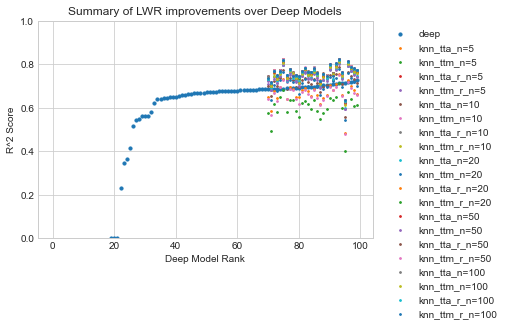

In [16]:
#graph our deep models by rank - plot - then overlay our knn moels

deep_set = scores_df[scores_df["predictor"]=="deep"].sort_values("R2")
deep_set["order"] = [i for i in range(0,100)]
deep_ordering = {row["model_num"]:row["order"] for index, row in deep_set.iterrows()}

def order_models(x):
    x = [deep_ordering[i] for i in x]
    return x

fig, ax = plt.subplots()
set_deep = False
knn_models = scores_df["predictor"].unique()
for knn_model in knn_models:
    subset = scores_df[scores_df["predictor"]==knn_model]
    s=3
    if knn_model == "deep":
        s=10
    ax.scatter(x=order_models(subset["model_num"].tolist()), y=subset["R2"], s=s, label=knn_model)

#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,1)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("R^2 Score")
ax.set_xlabel("Deep Model Rank")
#ax.set_ylim(0,200)
#ax.set_yscale("symlog")
ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"summary_plot.png", bbox_inches='tight')

In [17]:
scores_df_base = scores_df[scores_df["predictor"]=='deep']
scores_df_uu = scores_df[scores_df["predictor"].str.contains('_uu')]   #val_eq_list(scores_df["predictor"],'dist')] #np.logical_or(scores_df["predictor"]=="deep",'dist' in scores_df["predictor"])]
scores_df_ut = scores_df[scores_df["predictor"].str.contains('_ut')] 
scores_df_tu = scores_df[scores_df["predictor"].str.contains('_tu')]   #val_eq_list(scores_df["predictor"],'dist')] #np.logical_or(scores_df["predictor"]=="deep",'dist' in scores_df["predictor"])]
scores_df_tta = scores_df[scores_df["predictor"].str.contains('_tta')] 
scores_df_ttm = scores_df[scores_df["predictor"].str.contains('_ttm')] 

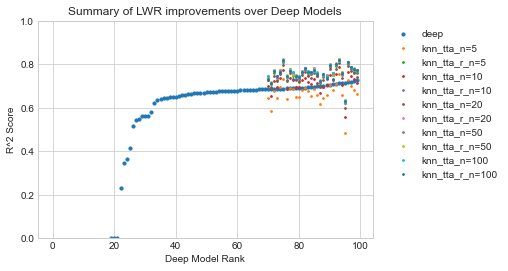

In [18]:
fig, ax = plt.subplots()
knn_models = scores_df_tta["predictor"].unique()
ax.scatter(x=order_models(scores_df_base["model_num"].tolist()), y=scores_df_base["R2"], s=10, label='deep')
for knn_model in knn_models:
    subset = scores_df_tta[scores_df_tta["predictor"]==knn_model]
    s=3
    ax.scatter(x=order_models(subset["model_num"].tolist()), y=subset["R2"], s=s, label=knn_model)

#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,1)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("R^2 Score")
ax.set_xlabel("Deep Model Rank")
#ax.set_ylim(0,200)
#ax.set_yscale("symlog")
ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"summary_plot_tta.png", bbox_inches='tight')


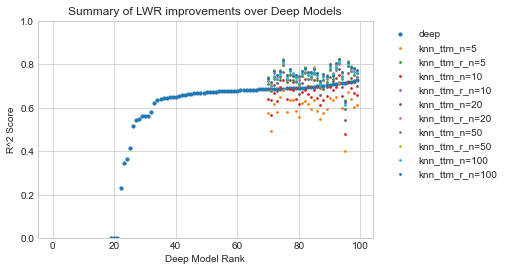

In [19]:
fig, ax = plt.subplots()
knn_models = scores_df_ttm["predictor"].unique()
ax.scatter(x=order_models(scores_df_base["model_num"].tolist()), y=scores_df_base["R2"], s=10, label='deep')
for knn_model in knn_models:
    subset = scores_df_ttm[scores_df_ttm["predictor"]==knn_model]
    s=3
    ax.scatter(x=order_models(subset["model_num"].tolist()), y=subset["R2"], s=s, label=knn_model)

#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,1)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("R^2 Score")
ax.set_xlabel("Deep Model Rank")
#ax.set_ylim(0,200)
#ax.set_yscale("symlog")
ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"summary_plot_ttm.png", bbox_inches='tight')


ValueError: operands could not be broadcast together with shapes (30,) (100,) 

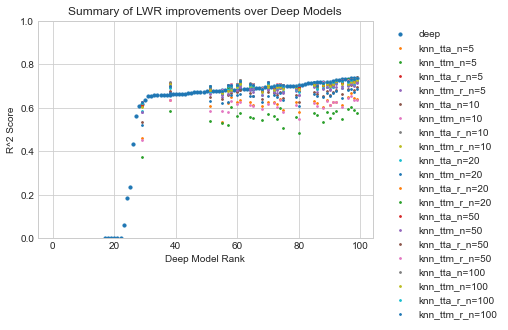

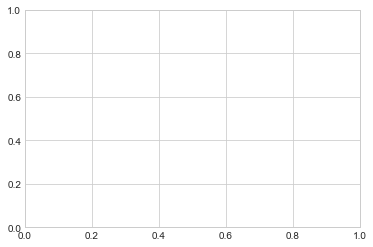

In [20]:
#graph our deep models by rank on final set - plot - then overlay our knn moels

deep_set = scores_df_final[scores_df_final["predictor"]=="deep"].sort_values("R2")
deep_set["order"] = [i for i in range(0,100)]
deep_ordering = {row["model_num"]:row["order"] for index, row in deep_set.iterrows()}

def order_models(x):
    x = [deep_ordering[i] for i in x]
    return x

fig, ax = plt.subplots()
set_deep = False
knn_models = scores_df_final["predictor"].unique()
for knn_model in knn_models:
    subset = scores_df_final[scores_df_final["predictor"]==knn_model]
    s=3
    if knn_model == "deep":
        s=10
    ax.scatter(x=order_models(subset["model_num"].tolist()), y=subset["R2"], s=s, label=knn_model)

#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,1)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("R^2 Score")
ax.set_xlabel("Deep Model Rank")
#ax.set_ylim(0,200)
#ax.set_yscale("symlog")
ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"summary_plot_final.png", bbox_inches='tight')

fig, ax = plt.subplots()
set_deep = False
knn_models = scores_df_final["predictor"].unique()
for knn_model in knn_models:
    subset = scores_df_final[scores_df_final["predictor"]==knn_model]
    s=3
    if knn_model == "deep":
        pass
    else:
        y1 = subset["R2"].to_numpy() - scores_df_final[scores_df_final["predictor"]=='deep']["R2"].to_numpy()
        ax.scatter(x=order_models(subset["model_num"].tolist()), y=y1, s=s, label=knn_model)

#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,1)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("R^2 Score")
ax.set_xlabel("Deep Model Rank")
#ax.set_ylim(0,200)
#ax.set_yscale("symlog")
ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"improvement_plot_final.png", bbox_inches='tight')